In [18]:
!pip install ydata_profiling
from dataclasses import dataclass

import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn 
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

from ydata_profiling import ProfileReport
from helpers import *

%matplotlib inline

# Exploratory Data Analysis

In [19]:
data = pd.read_csv('ConcreteStrengthData.csv')
data.columns = data.columns.str.strip()

In [20]:
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)
# profile.to_file("report.html")

Опис полів:

- **CementComponent**: Кількість цементу
- **BlastFurnaceSlag**: Кількість шлаку з доменної печі
- **FlyAshComponent**: Кількість леткої золи
- **WaterComponent**: Кількість води
- **SuperplasticizerComponent**: Кількість суперпластифікатора
- **CoarseAggregateComponent**: Кількість крупного заповнювача
- **FineAggregateComponent**: Кількість дрібного заповнювача
- **AgeInDays**: Скільки днів бетон залишали сохнути
- **Strength**: Яка була кінцева міцність бетону (цільовий показник)

In [21]:
data.drop_duplicates(inplace=True)
data.columns = data.columns.str.strip()

In [22]:
# features = list(data.columns)
# fig, axes = plt.subplots(len(features), 3, figsize=(20, 45))

# for f, (ax1, ax2, ax3) in enumerate(axes):
#     sns.histplot(data[features[f]], ax=ax1, color='orange')
#     sns.kdeplot(data[features[f]], ax=ax1, color='black')
#     sns.boxplot(x=data[features[f]], ax=ax2, color='lightblue')
#     probplot(data[features[f]], plot=ax3)

# fig.suptitle('Data Distribution in Training Set', fontsize=18, fontweight='bold', y=1)
# plt.tight_layout()
# # plt.savefig("plot.png", format="png", dpi=300, bbox_inches="tight")
# plt.show()

In [23]:
# features = set(data.columns)
# features = list(features)
# fig, axes = plt.subplots(len(features)//3+1,3,figsize=(20,15))

# f = 0
# for axs in axes:
#     for ax in axs:
#         if f == len(features): break
#         sns.regplot(x=features[f],y='Strength',data=data,color='#E4E9CE',line_kws={'color':'green'},ax=ax)
#         f += 1

# fig.suptitle('Direct Relationship of Each Features and Target',y=0.95,fontsize=22,fontweight='bold')
# plt.savefig("Direct.png", format="png", dpi=300, bbox_inches="tight")
# plt.show()

- **Позитивно корельовані ознаки**: `CementComponent`, `AgeInDays`, `FlyAshComponent`, `SuperplasticizerComponent`, `BlastFurnaceSlag`. Ці ознаки показують, що їх збільшення може призвести до підвищення міцності.
- **Негативно корельовані ознаки**: `WaterComponent`, `FineAggregateComponent`, `CoarseAggregateComponent`. Ці ознаки вказують на можливе зниження міцності при збільшенні їхньої кількості.

Загалом, `CementComponent` та `AgeInDays` є найбільш значущими у підвищенні міцності, тоді як велика кількість води і дрібного заповнювача можуть мати негативний ефект.

In [24]:
# fig, axes = plt.subplots(len(features)//3+1,3,figsize=(20,15))

# f = 0
# for axs in axes:
#     for ax in axs:
#         if f == len(features): break
#         sns.boxplot(x=features[f],y='Strength',data=data,ax=ax)
#         f += 1

# fig.suptitle('Direct Relationship of Each Features and Target',y=0.95,fontsize=22,fontweight='bold') 
# plt.show()

Цей графік відображає взаємозв'язок між кожною ознакою та цільовою змінною `Strength` (міцність) у цьому наборі даних. Основні спостереження:

- **AgeInDays**: Помітна позитивна залежність – зі збільшенням віку матеріалу міцність зростає. Це відповідає очікуванням, оскільки матеріал твердне з часом.
- **CementComponent**: Спостерігається слабка позитивна кореляція – більший вміст цементу зазвичай пов'язаний із вищою міцністю, що логічно, оскільки цемент зміцнює структуру.
- **WaterComponent**: Ледь виражена негативна тенденція, де надмірна кількість води може знижувати міцність через пористість.
- **Інші компоненти (SuperplasticizerComponent, FlyAshComponent, FineAggregateComponent, CoarseAggregateComponent, BlastFurnaceSlag)**: Ці ознаки не мають сильної кореляції з міцністю, проте присутні деякі варіації та викиди.

Загалом, `AgeInDays` та `CementComponent` є ключовими факторами, що позитивно впливають на міцність, тоді як збільшення вмісту води може мати негативний ефект.

Ми застосовуємо вінзоризацію до `SuperplasticizerComponent`, `AgeInDays` та `WaterComponent`, щоб зменшити вплив екстремальних викидів. Ці ознаки мають асиметричний розподіл із дуже високими або низькими значеннями, які можуть спотворити аналіз або знизити продуктивність моделі. Вінзоризація обрізає ці екстремальні значення, щоб зменшити асиметрію, зробити дані більш стійкими та покращити стабільність моделі без втрати важливої інформації з набору даних.

In [25]:
data_w = data.copy()
for col in data_w.columns:
    if col in ['SuperplasticizerComponent','AgeInDays','WaterComponent']:
        data_w = winsorize(data_w,col,97.5,0.025)

In [26]:
data['cement-water ratio'] = data['CementComponent'] / data['WaterComponent']
data['aggregate-cement ratio'] = (data['FineAggregateComponent'] + data['CoarseAggregateComponent']) / data['CementComponent']
data['age_cement'] = data['CementComponent'] / data['AgeInDays']
data['superplasticizer-cement ratio'] = data['SuperplasticizerComponent'] / data['CementComponent']

data_w['cement-water ratio'] = data_w['CementComponent'] / data_w['WaterComponent']
data_w['aggregate-cement ratio'] = (data_w['FineAggregateComponent'] + data_w['CoarseAggregateComponent']) / data_w['CementComponent']
data_w['age_cement'] = data_w['CementComponent'] / data_w['AgeInDays']
data_w['superplasticizer-cement ratio'] = data_w['SuperplasticizerComponent'] / data_w['CementComponent']

In [27]:
# features = set(data.columns).difference({'Generated', 'Strength', 'Strength_boxcox'})
# features = list(features)
# fig, axes = plt.subplots(len(features) // 3, 3, figsize=(20, 25))

# f = 0
# for axs in axes:
#     for ax in axs:
#         if f == len(features): 
#             break
#         sns.histplot(data[features[f]], ax=ax, color="#d4d700", label='original data', kde=True)
#         sns.histplot(data_w[features[f]], ax=ax, color="#a2d6f9", label='winsorized data', kde=True).lines[0].set_color('#e9ff70')
#         ax.legend()
#         f += 1

# fig.suptitle('Data Distribution', fontsize=22, fontweight='bold', y=1)
# plt.tight_layout()
# plt.savefig("original|winsored.png", format="png", dpi=300, bbox_inches="tight")
# plt.show()

- **Основний ефект вінзоризації**: Вінзоризація ефективно обмежила екстремальні значення у кожній ознаці, зменшуючи вплив викидів та асиметрії без суттєвої зміни загального розподілу.
- **Стабілізовані дані**: Такий підхід допомагає стабілізувати набір даних, роблячи його більш придатним для моделювання, оскільки зменшує потенційний вплив викидів, які можуть спотворити прогнози або збільшити варіативність моделі.
- **Збережена форма розподілу**: Для більшості ознак основна форма розподілу збережена, що означає, що вінзоризація є обережною і не трансформує характеристики даних суттєво.

In [28]:
# heatmap_corr(data,'Data Correlation')
# heatmap_corr(data_w,'Data (Winsorized) Correlation')

Загалом, вінзоризація трохи стабілізувала кореляційні значення, зменшивши вплив екстремальних значень, що робить набір даних більш надійним для подальшого аналізу та моделювання.

In [29]:
data = data_w

In [30]:
target_column = 'Strength'
X = data.drop(columns=[target_column])
y = data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [31]:
input_size = data.drop(columns=[target_column]).shape[1] 
hidden_size = 20     
output_size = 1      
learning_rate = 0.01 
batch_size = 32      
num_epochs = 200    

In [32]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [33]:
model = NeuralNetwork(input_size, hidden_size, output_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [34]:
loss_values = []
train_dataset = TensorDataset(torch.tensor(X_train_scaled.values, dtype=torch.float32),
                              torch.tensor(y_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = loss_function(predictions, y_batch.unsqueeze(1))  # y_batch.unsqueeze(1) для вирівнювання розмірностей
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    average_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(average_epoch_loss)
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_epoch_loss:.4f}")

In [35]:
model.eval()

# Перетворення тестових даних у тензори
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Отримання прогнозів
with torch.no_grad():  # Вимикає обчислення градієнтів для швидшої обробки
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()  # Конвертуємо прогноз у numpy для обчислення метрик
    y_test = y_test_tensor.numpy()  # Конвертуємо цільову змінну в numpy

# Обчислення метрик ефективності
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Виведення результатів
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 298.8448
Mean Absolute Error (MAE): 13.9780
R² Score: -0.0017


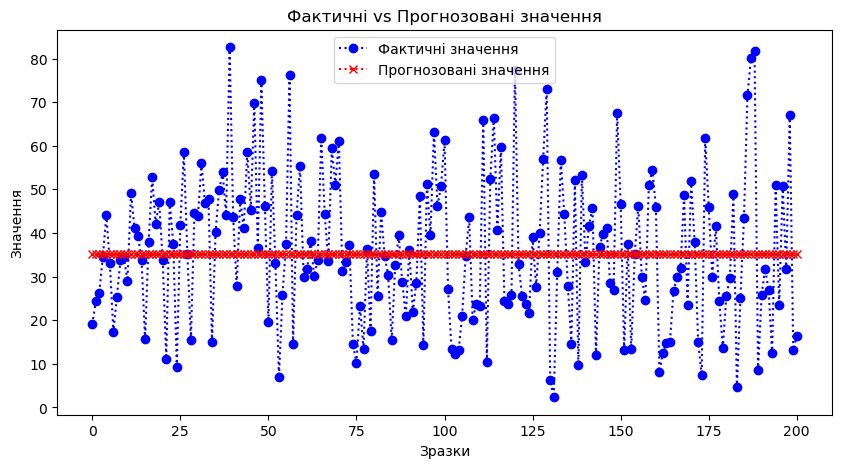

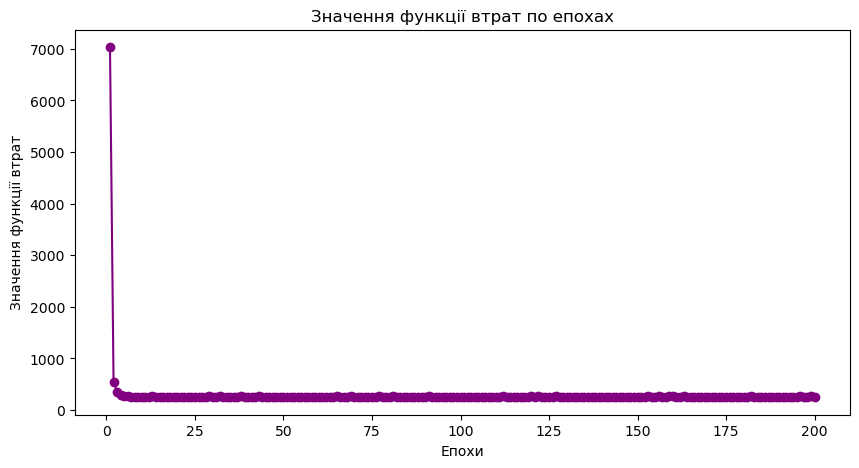

In [36]:
# Побудова графіка фактичних і прогнозованих значень
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Фактичні значення', color='blue', marker='o', linestyle='dotted')
plt.plot(y_pred, label='Прогнозовані значення', color='red', marker='x', linestyle='dotted')
plt.xlabel("Зразки")
plt.ylabel("Значення")
plt.title("Фактичні vs Прогнозовані значення")
plt.legend()
plt.show()

# 2. Графік значень функції втрат
# Побудова графіка втрат по епохах
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='purple')
plt.xlabel("Епохи")
plt.ylabel("Значення функції втрат")
plt.title("Значення функції втрат по епохах")
plt.show()